In [1]:
# Import the ensamble model VotingClassifier
from sklearn.ensemble import VotingClassifier
from casestudy_tools import preprocess

In [2]:
# Gets the preprocessed data set for Organics.
df = preprocess()

# Import necssary packages
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Sets target column to ORGYN
target_dataset = df['ORGYN']
# Removes ORGYN from the dataset in order to avoid false predictor.
dataset = df.drop(['ORGYN'], axis=1)

# Sets random state to 10. This will be kept consistently throughout the case study.
random_state = 10
# Sets the test size to be 30% of the total data set.
test_size = 0.3

# Transform the dataset into a matrix.
dataset_matrix = dataset.as_matrix()

# Splits the data into train and test sets.
dataset_train, dataset_test, target_dataset_train, target_dataset_test = train_test_split(dataset_matrix, target_dataset, test_size=test_size, stratify=target_dataset, random_state=random_state)

# Updates the global variables with the test and train data
dt_x_train = dataset_train
dt_x_test = dataset_test
dt_y_train = target_dataset_train
dt_y_test = target_dataset_test


# GridSearchCV parameters
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 5),
          'min_samples_leaf': range(1, 2)}

cross_validation_optimal_model = GridSearchCV(param_grid=params,
                                      estimator=DecisionTreeClassifier(random_state=random_state),
                                      cv=10)
cross_validation_optimal_model.fit(dataset_train, target_dataset_train)

train_accuracy_optimal_cv = cross_validation_optimal_model.score(dataset_train, target_dataset_train)
test_accuracy_optimal_cv = cross_validation_optimal_model.score(dataset_test, target_dataset_test)

# test the best model
target_prediction = cross_validation_optimal_model.predict(dataset_test)

    # Prints train and test accuracy.
print("CV Tuned Decision Tree Statistics:")
print("Train Accuracy:", cross_validation_optimal_model.score(dataset_train, target_dataset_train))
print("Test Accuracy:", cross_validation_optimal_model.score(dataset_test, target_dataset_test))

# Printing a classification report of the model.
print("")
print("Classification Report:")
target_predict = cross_validation_optimal_model.predict(dataset_test)
print(classification_report(target_dataset_test, target_predict))
print("Number of nodes in the decision tree:", cross_validation_optimal_model.best_estimator_.tree_.node_count)

dt_model = cross_validation_optimal_model.best_estimator_

CV Tuned Decision Tree Statistics:
Train Accuracy: 0.818012342504
Test Accuracy: 0.81580920954

Classification Report:
             precision    recall  f1-score   support

          0       0.83      0.95      0.89      5015
          1       0.72      0.42      0.53      1652

avg / total       0.80      0.82      0.80      6667

Number of nodes in the decision tree: 31


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# preprocessing step
df = preprocess()

# random state
rs = 10

# train test split
y = df['ORGYN']
X = df.drop(['ORGYN'], axis=1)
X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)


# initialise a standard scaler object
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

df_log = df.copy()

#Create X, y and train test data partitions
# create X, y and train test data partitions
y_log = df_log['ORGYN']
X_log = df_log.drop(['ORGYN'], axis=1)
X_mat_log = X_log.as_matrix()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y_log, test_size=0.3, stratify=y_log, 
                                                                    random_state=rs)

# standardise them again
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

print("Using RFECV")
#Q3 Feature Transformation
from sklearn.feature_selection import RFECV
rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train) # run the RFECV

print("RFECV")

#test the performance
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

from sklearn.tree import DecisionTreeClassifier
from casestudy_tools import get_decision_tree
#from casestudy_tools import analyse_feature_importance

params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 5),
          'min_samples_leaf': range(1,2)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train_log, y_train_log)


from sklearn.feature_selection import SelectFromModel

# use the trained best decision tree from GridSearchCV to select features
# supply the prefit=True parameter to stop SelectFromModel to re-train the model
selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train_log)
X_test_sel_model = selectmodel.transform(X_test_log)

# Grid search cv for RFE SELECTION MODEL (BEST MODEL)
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel_model, y_train_log)

print("Logistic Regression Model Statistics:")
print("Train accuracy:", cv.score(X_train_sel_model, y_train_log))
print("Test accuracy:", cv.score(X_test_sel_model, y_test_log))

log_reg_x_train = X_train_sel_model
log_reg_x_test  = X_test_sel_model
log_reg_y_train = y_train_log
log_reg_y_test  = y_test_log

# test the best model
y_pred = cv.predict(X_test_sel_model)
print("Classification Report:")
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)


log_reg_model = cv.best_estimator_

Using RFECV
RFECV
Logistic Regression Model Statistics:
Train accuracy: 0.811519670867
Test accuracy: 0.816709164542
Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.94      0.89      5015
          1       0.71      0.44      0.54      1652

avg / total       0.80      0.82      0.80      6667

{'C': 1e-06}


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

rs = 10

 # Gets the preprocessed data set for Organics.
df = preprocess()

y = df['ORGYN']
X = df.drop(['ORGYN'], axis=1)
X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

# Updates the global variables with the test and train data
nn_x_train = X_train
nn_x_test = X_test
nn_y_train = y_train
nn_y_test = y_test



params = {'hidden_layer_sizes': [(3)], 'alpha': [0.0001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

y_pred = cv.predict(X_test)
print("Neural Network Model Statistics:")
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

nn_x_train = X_train
nn_x_test  = X_test
nn_y_train = y_train
nn_y_test  = y_test

y_pred = cv.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

nn_model = cv.best_estimator_

Neural Network Model Statistics:
Train accuracy: 0.814412445359
Test accuracy: 0.818959052047
Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.94      0.89      5015
          1       0.72      0.44      0.55      1652

avg / total       0.81      0.82      0.80      6667



In [5]:
# initialise the classifier with 3 different estimators
ensemble_voting_model = VotingClassifier(estimators=[('dt', dt_model), ('lr', log_reg_model), ('nn', nn_model)], voting='soft')

In [7]:
# Divides a new set of training and testdata from the given dataset.
df = preprocess()

# Building a decision tree using the default settings.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Sets target column to ORGYN
target_dataset = df['ORGYN']
# Removes ORGYN from the dataset in order to avoid false predictor.
dataset = df.drop(['ORGYN'], axis=1)

# Sets random state to 10. This will be kept consistently throughout the case study.
random_state = 10
# Sets the test size to be 30% of the total data set.
test_size = 0.3

# Transform the dataset into a matrix.
dataset_matrix = dataset.as_matrix()

# Splits the data into train and test sets.
dataset_train, dataset_test, target_dataset_train, target_dataset_test = train_test_split(dataset_matrix,
                                                                                          target_dataset,
                                                                                          test_size=test_size,
                                                                                          stratify=target_dataset,
                                                                                          random_state=random_state
                                                                                         )

scaler = StandardScaler()
dataset_train_scaled = scaler.fit_transform(dataset_train, target_dataset_train)
dataset_test_scaled = scaler.transform(dataset_test)


In [8]:
# Needed for accuracy score
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

# fit the voting classifier to training data
ensemble_voting_model.fit(dataset_train_scaled, target_dataset_train)

# evaluate train and test accuracy
print("Ensemble soft train accuracy:", ensemble_voting_model.score(dataset_train_scaled, target_dataset_train))
print("Ensemble soft test accuracy:", ensemble_voting_model.score(dataset_test_scaled, target_dataset_test))

# evaluate ROC auc score
y_pred_proba_ensemble = ensemble_voting_model.predict_proba(dataset_test_scaled)
roc_index_ensemble = roc_auc_score(target_dataset_test, y_pred_proba_ensemble[:, 1])
print("ROC score of soft voting classifier:", roc_index_ensemble)

y_pred_ensemble = ensemble_voting_model.predict(dataset_test_scaled)
print("Classification Report for Ensemble:")
print(classification_report(target_dataset_test, y_pred_ensemble))



Ensemble soft train accuracy: 0.817626639239
Ensemble soft test accuracy: 0.821508924554
ROC score of soft voting classifier: 0.826314337858
Classification Report for Ensemble:
             precision    recall  f1-score   support

          0       0.84      0.95      0.89      5015
          1       0.74      0.44      0.55      1652

avg / total       0.81      0.82      0.80      6667



<h2>Task 5.2</h2>

In [9]:

y_pred_dt = dt_model.predict(dt_x_test)
y_pred_log_reg = log_reg_model.predict(log_reg_x_test)
y_pred_nn = nn_model.predict(nn_x_test)

print("Accuracy score on test for Decision Tree:", accuracy_score(dt_y_test, y_pred_dt))
print("Accuracy score on test for logistic regression:", accuracy_score(log_reg_y_test, y_pred_log_reg))
print("Accuracy score on test for Neural Networks:", accuracy_score(nn_y_test, y_pred_nn))
print("Accuracy score on test for Ensemble:", accuracy_score(target_dataset_test, y_pred_ensemble))

Accuracy score on test for Decision Tree: 0.81580920954
Accuracy score on test for logistic regression: 0.816709164542
Accuracy score on test for Neural Networks: 0.818959052047
Accuracy score on test for Ensemble: 0.821508924554


In [10]:
print("Classification Report for Decision Tree:")
print(classification_report(dt_y_test, y_pred_dt))
print("Classification Report for logistic regression:")
print(classification_report(log_reg_y_test, y_pred_log_reg))
print("Classification Report for Neural Networks:")
print(classification_report(nn_y_test, y_pred_nn))
print("Classification Report for Ensemble:")
print(classification_report(target_dataset_test, y_pred_ensemble))

Classification Report for Decision Tree:
             precision    recall  f1-score   support

          0       0.83      0.95      0.89      5015
          1       0.72      0.42      0.53      1652

avg / total       0.80      0.82      0.80      6667

Classification Report for logistic regression:
             precision    recall  f1-score   support

          0       0.84      0.94      0.89      5015
          1       0.71      0.44      0.54      1652

avg / total       0.80      0.82      0.80      6667

Classification Report for Neural Networks:
             precision    recall  f1-score   support

          0       0.84      0.94      0.89      5015
          1       0.72      0.44      0.55      1652

avg / total       0.81      0.82      0.80      6667

Classification Report for Ensemble:
             precision    recall  f1-score   support

          0       0.84      0.95      0.89      5015
          1       0.74      0.44      0.55      1652

avg / total       0.81     

In [11]:

y_pred_proba_dt = dt_model.predict_proba(dt_x_test)
y_pred_proba_log_reg = log_reg_model.predict_proba(log_reg_x_test)
y_pred_proba_nn = nn_model.predict_proba(nn_x_test)
y_pred_proba_ensemble = ensemble_voting_model.predict_proba(dataset_test_scaled)

roc_index_dt = roc_auc_score(dt_y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(log_reg_y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(nn_y_test, y_pred_proba_nn[:, 1])
roc_index_ensemble = roc_auc_score(target_dataset_test, y_pred_proba_ensemble[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)
print("ROC index on test for Ensemble:", roc_index_ensemble)

ROC index on test for DT: 0.818589147811
ROC index on test for logistic regression: 0.811653417472
ROC index on test for NN: 0.817044085661
ROC index on test for Ensemble: 0.826314337858


In [12]:
from sklearn.metrics import roc_curve

# Gets the false positive rate, true positive rate and thresholds used for each model
fpr_dt, tpr_dt, thresholds_dt = roc_curve(dt_y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(log_reg_y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(nn_y_test, y_pred_proba_nn[:,1])
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(target_dataset_test, y_pred_proba_ensemble[:,1])

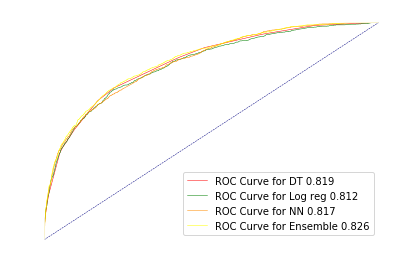

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Sets the color to white.
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)
plt.plot(fpr_ensemble, tpr_ensemble, label='ROC Curve for Ensemble {:.3f}'.format(roc_index_ensemble), color='yellow', lw=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC chart for predicting organic purchase', color="w")
plt.legend(loc="lower right")
plt.show()